In [1]:
# Import the libraries
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, mutual_info_classif
from gensim.models import Word2Vec
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('all')
nltk.download('stopwords')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/vishalsehgal/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/vishalsehgal/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/vishalsehgal/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/vishalsehgal/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/vishalsehgal/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru

True

# Pre-Processing

In [2]:
# Load the processed data from CSV
us_df = pd.read_csv("us_equities_news_dataset.csv")
nvda_df = pd.read_csv("nvda.csv")

In [3]:
print(us_df.columns)
print(nvda_df.columns)

Index(['id', 'ticker', 'title', 'category', 'content', 'release_date',
       'provider', 'url', 'article_id'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [4]:
# Filter articles for NVDA and Nvidia only because we only require articles related to Nvidia not other companies.
nvda_articles = us_df[
    (us_df['ticker'] == 'NVDA') |  
    (us_df['title'].str.contains('nvidia', case=False, na=False)) |  
    (us_df['content'].str.contains('nvidia', case=False, na=False)) |
    (us_df['title'].str.contains('nvda', case=False, na=False)) |
    (us_df['content'].str.contains('nvda', case=False, na=False))
]
print(f"Number of articles related to Nvidia: {nvda_articles.shape[0]}")

Number of articles related to Nvidia: 3464


In [5]:
# remove duplicates contents and titles
nvda_articles = nvda_articles.drop_duplicates(subset=['content', 'title'])
print(f"Number of articles related to Nvidia after removing duplicates: {nvda_articles.shape[0]}")


Number of articles related to Nvidia after removing duplicates: 3450


In [6]:
# Convert 'release_date' and 'Date' to datetime 
# Did copy bcoz i was getting a warning
nvda_articles = nvda_articles.copy() 
nvda_articles['release_date'] = pd.to_datetime(nvda_articles['release_date'])
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])

In [7]:
nvda_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1,1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
2,1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
3,1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000
4,1999-01-29,0.041536,0.041667,0.039583,0.039583,0.036307,244032000
...,...,...,...,...,...,...,...
6432,2024-08-16,121.940002,125.000000,121.180000,124.580002,124.580002,302589900
6433,2024-08-19,124.279999,130.000000,123.419998,130.000000,130.000000,318333600
6434,2024-08-20,128.399994,129.880005,125.889999,127.250000,127.250000,300087400
6435,2024-08-21,127.320000,129.350006,126.660004,128.500000,128.500000,256985000


In [8]:
# Filter the columns so that i dont have to see all the columns
nvda_stock = nvda_df[['Date', 'Open', 'Close']]

# Create labels for the articles

In [9]:
# Merge articles with stock prices based on the date
merged_df = pd.merge(
    nvda_articles,
    nvda_stock,  
    left_on='release_date',
    right_on='Date',
    how='left'  
)

In [10]:
merged_df = merged_df.dropna(subset=['Open', 'Close'])

In [11]:
print(merged_df.columns)

Index(['id', 'ticker', 'title', 'category', 'content', 'release_date',
       'provider', 'url', 'article_id', 'Date', 'Open', 'Close'],
      dtype='object')


In [12]:
def preprocess_text(text):
    
    # Check if the text is a string
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase bcoz we dont want to differentiate between words like 'Nvidia' and 'nvidia'
    text = text.lower()
    
    # Remove punctuation except for $ and % bcoz they are important for stock data
    # use nltk punctuation to remove the punctuation
    text = ''.join([char for char in text if char not in string.punctuation or char in ['$','%']])
    
    # Tokenize the text bcoz we want to remove stop words so it helps in breaking the text into words
    # use nltk word_tokenize to tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stop words bcoz they are common words that do not carry much information. I added english and spanish both as US have 2 common languages.
    stop_words_en = set(stopwords.words('english'))
    stop_words_es = set(stopwords.words('spanish'))
    stop_words = stop_words_en.union(stop_words_es)
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize the words bcoz it helps in reducing the words to their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # remove single words bcoz they are not useful for our analysis as when i checked 50 commonwords there was words like "u" and "p" which makes no sense
    words = [word for word in words if len(word) > 1]
    
    # Remove unwanted numbers bcoz they are not useful for our analysis as we are working on text and we are not removing financial symbols and numbers becasue they are important for stock data
    processed_words = []
    units = ['million', 'billion', 'trillion', 'thousand', 'hundred']
    
    i = 0
    while i < len(words):
        word = words[i]
        keep_word = True
        
        # Check if the word is a number
        if word.isdigit():
            keep_word = False  # Default to not keeping the word

            # Check if previous word is $ or usd
            if i > 0 and words[i - 1] in ['$', 'usd']:
                keep_word = True
            # Check if next word is % or a unit
            elif i + 1 < len(words) and (words[i + 1] in ['%', 'percent'] or words[i + 1] in units):
                keep_word = True
            # Check if word contains $ or %
            elif '$' in word or '%' in word:
                keep_word = True

        if keep_word:
            processed_words.append(word)
        
        i += 1
    
    # Join the words back into a string 
    clean_text = ' '.join(processed_words)
    
    return clean_text

In [13]:
# make a copy because i was getting a warning
merged_df = merged_df.copy()
# Apply the preprocessing function to the 'content' column
merged_df['clean_content'] = merged_df['content'].apply(preprocess_text)

In [14]:
# Create labels based on stock price movement as 1 for increase and 0 for decrease.
merged_df['label'] = (merged_df['Close'] > merged_df['Open']).astype(int)
label_counts = merged_df['label'].value_counts()

In [15]:
print("Label distribution:")
print(label_counts)

Label distribution:
label
1    1657
0    1446
Name: count, dtype: int64


Descriptive Statistics

In [16]:
# Calculate the number of articles 
print(f"Number of artikles:{merged_df.shape[0]}")

Number of artikles:3103


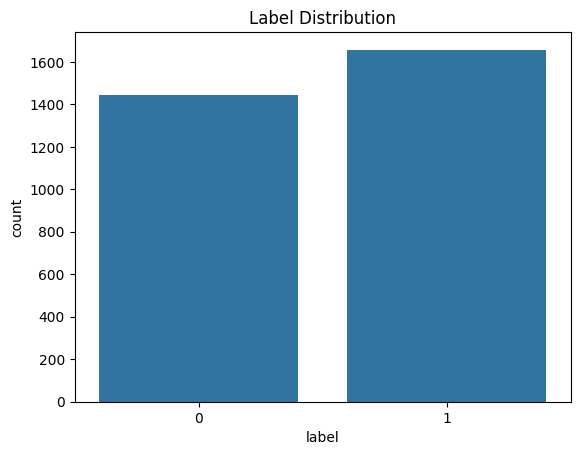

In [17]:
# plot the distribution of labels
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=merged_df, x='label')
plt.title('Label Distribution')
plt.show()


In [18]:
# calculate the average number of words per article
print(f"Average words per artikle: {merged_df['clean_content'].apply(lambda x: len(x.split())).mean():.2f}")

Average words per artikle: 389.71


In [19]:
# Calculate the unique words 
unique_words = Counter()
merged_df['clean_content'].str.split().apply(unique_words.update)
print(f"Number of unique words: {len(unique_words)}")

Number of unique words: 29908


In [20]:
# calculate lexical richness: unique words / total words be
print(f"Lexical richness: {len(unique_words) / merged_df['clean_content'].apply(lambda x: len(x.split())).sum():.2f}")

Lexical richness: 0.02


In [21]:
# caLculate most common 50 words in corpus after stop words removed
# use counter()
most_common_words = Counter()
merged_df['clean_content'].str.split().apply(most_common_words.update)
print("Most common words:")
print(most_common_words.most_common(50))

Most common words:
[('year', 14210), ('company', 13367), ('stock', 13292), ('nasdaq', 13264), ('zacks', 9618), ('market', 8971), ('earnings', 8511), ('nvidia', 8076), ('quarter', 7568), ('share', 7328), ('revenue', 6483), ('growth', 6350), ('billion', 5616), ('also', 5503), ('nyse', 5442), ('technology', 4972), ('estimate', 4609), ('new', 4543), ('investor', 4419), ('million', 4362), ('last', 4119), ('inc', 4037), ('rank', 3972), ('expected', 3758), ('week', 3638), ('day', 3619), ('price', 3561), ('nvda', 3535), ('report', 3514), ('trade', 3485), ('one', 3422), ('time', 3393), ('data', 3372), ('buy', 3353), ('high', 3307), ('investment', 3273), ('industry', 3185), ('like', 3170), ('strong', 3162), ('per', 3148), ('chip', 3103), ('index', 3057), ('top', 2950), ('analyst', 2922), ('intel', 2900), ('said', 2828), ('semiconductor', 2820), ('see', 2802), ('sector', 2799), ('product', 2750)]


<Axes: title={'center': 'Most common words'}, xlabel='word'>

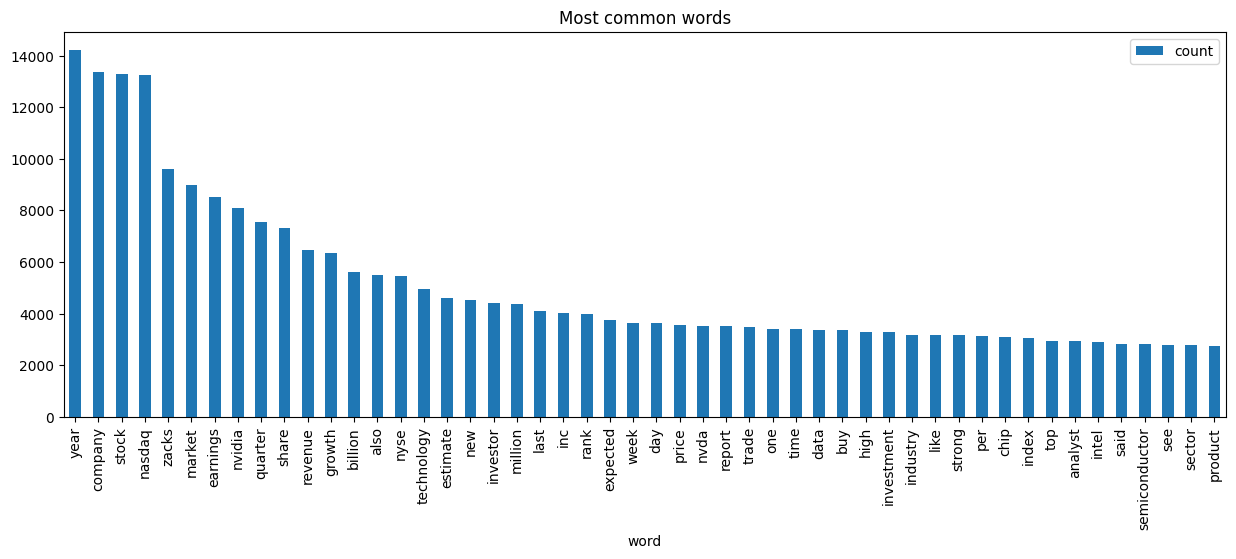

In [22]:
# Plot 50 most common words
most_common_words_df = pd.DataFrame(most_common_words.most_common(50), columns=['word', 'count'])
most_common_words_df.plot(kind='bar', x='word', y='count', figsize=(15, 5), title='Most common words')

In [23]:
# create the document term matrix
vectorizer = CountVectorizer()
dtm_x = vectorizer.fit_transform(merged_df['clean_content'])
feature_names = vectorizer.get_feature_names_out()

# train the logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(dtm_x, merged_df['label'])

# extract the coefficients
coefficients = lr_model.coef_[0]
coefficients_df = pd.DataFrame({
    'features': feature_names,
    'coefficient': coefficients
})

# identify the most indicative words for each class
# for class 0
class_0_words = coefficients_df.sort_values('coefficient').head(20)
print("Most indicative words for class 0:")
print(class_0_words)

# for class 1
class_1_words = coefficients_df.sort_values('coefficient', ascending=False).head(20)
print("Most indicative words for class 1:")
print(class_1_words)

Most indicative words for class 0:
        features  coefficient
1783         80m    -0.826744
4859       board    -0.826301
18546       nice    -0.752916
10794  expanding    -0.736340
79           07m    -0.722719
25604      stiff    -0.695716
11235       fell    -0.694965
12181     gained    -0.681946
4559         bid    -0.668164
18274     nation    -0.664149
15414    journal    -0.653217
12459      giant    -0.642794
27550        ttm    -0.640044
19879     passed    -0.639562
29411    working    -0.639114
1954    9339past    -0.632543
4345     beating    -0.631133
27530        tsm    -0.623472
12671      googl    -0.620782
25769  streaming    -0.619805
Most indicative words for class 1:
            features  coefficient
554               21     1.005757
23306           rose     0.957386
2492       advancing     0.952543
25748     strategist     0.947454
23971          seems     0.924158
22500       remained     0.764243
9077   discretionary     0.730114
11492           flat     0.7

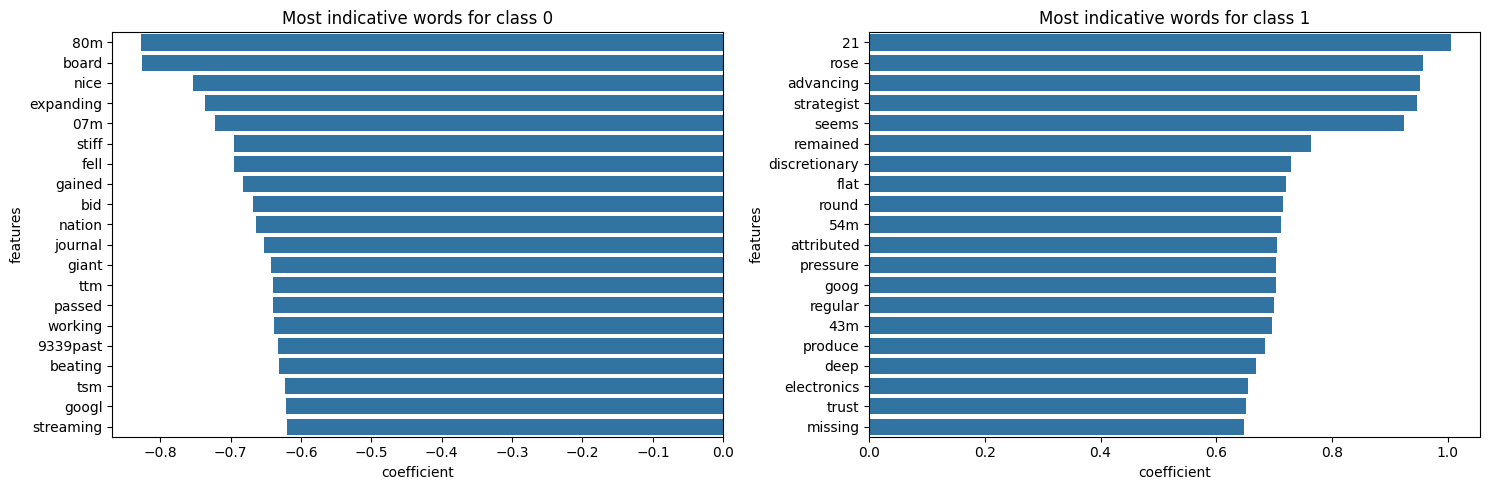

In [24]:
# plot the most indicative words
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=class_0_words, x='coefficient', y='features', ax=axes[0])
axes[0].set_title('Most indicative words for class 0')
sns.barplot(data=class_1_words, x='coefficient', y='features', ax=axes[1])
axes[1].set_title('Most indicative words for class 1')
plt.tight_layout()
plt.show()

After running and doing some reseach on the output of logistic regression , chisq, manual calculation, and mutual infornmation I  came to the conclusion that Logistic regression have most reliable and interpretable results.

# Text Representation and Modeling 

In [25]:
# Create the TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['clean_content'])

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

In [27]:
# Set self-similarities to zero
np.fill_diagonal(cosine_sim_matrix, 0)

# Find the indices of the most similar pair
most_similar_pair = np.unravel_index(np.argmax(cosine_sim_matrix), cosine_sim_matrix.shape)
max_similarity = cosine_sim_matrix[most_similar_pair]

print(f"Most similar pair of documents are at indices {most_similar_pair} with similarity {max_similarity:.4f}")

Most similar pair of documents are at indices (2649, 2809) with similarity 1.0000


In [28]:
# Mask zeros and find the least similar pair
masked_cosine_sim = np.where(cosine_sim_matrix == 0, np.inf, cosine_sim_matrix)
least_similar_pair = np.unravel_index(np.argmin(masked_cosine_sim), masked_cosine_sim.shape)
min_similarity = cosine_sim_matrix[least_similar_pair]

print(f"Least similar pair of documents are at indices {least_similar_pair} with similarity {min_similarity:.4f}")

Least similar pair of documents are at indices (63, 1668) with similarity 0.0000


In [29]:
# Inspect the most similar documents
doc1_index, doc2_index = most_similar_pair
doc1_content = merged_df.iloc[doc1_index]['content']
doc2_content = merged_df.iloc[doc2_index]['content']

print("\nMost Similar Documents:")
print(f"Document {doc1_index} :\n{doc1_content}\n")
print(f"Document {doc2_index} :\n{doc2_content}\n")


Most Similar Documents:
Document 2649 :
Investing com   NVIDIA  NASDAQ NVDA  fell by 3 03  to trade at  209 98 by 12 49  17 49 GMT  on Monday on the NASDAQ exchange 
The volume of NVIDIA shares traded since the start of the session was 5 00M  NVIDIA has traded in a range of  209 77 to  216 89 on the day 
The stock has traded at  221 4100 at its highest and  209 3100 at its lowest during the past seven days 

Document 2809 :
Investing com   NVIDIA  NASDAQ NVDA  fell by 3 05  to trade at  208 36 by 10 09  15 09 GMT  on Monday on the NASDAQ exchange 
The volume of NVIDIA shares traded since the start of the session was 2 00M  NVIDIA has traded in a range of  207 55 to  215 33 on the day 
The stock has traded at  222 0000 at its highest and  176 0100 at its lowest during the past seven days 



In [30]:

# Inspect the least similar documents
doc1_index_ls, doc2_index_ls = least_similar_pair
doc1_content_ls = merged_df.iloc[doc1_index_ls]['content']
doc2_content_ls = merged_df.iloc[doc2_index_ls]['content']

print("Least Similar Documents:")
print(f"Document {doc1_index_ls}:\n{doc1_content_ls}\n")
print(f"Document {doc2_index_ls}:\n{doc2_content_ls}\n")

Least Similar Documents:
Document 63:
AAXN  ACAD  ACIA  ALRM  APEI  ARNA  ATHX  AXAS  BUFF  CALX  CDXS  CHEF  CHMI  CLI  COGT  COHR  DEPO  DIOD  DIS  DOX  EA  ENPH  ESIO  EVH  EVRI  EXAR  FARM  FARO  FMI  FNV  FOSL  FTD  FUEL  GDOT  GERN  GHDX  GWPH  HALO  HCKT  IAG  INFI  INGN  IOSP  IPAR  JAZZ  KAR  LADR  LGND  MCF  MCHP  MIME  MMI  MRIN  MTRX  MXL  MXWL  NBIX  NDLS  NEWR  NKTR  NUAN  NVDA  NWSA  OREX  OVAS  PAAS  PCLN  PEIX  PEN  PFMT  PHH  PRAA  PRI  PRMW  PRTA  PSEC  QNST  REG  REXX  RMTI  RPD  RVNC  SCSC  SGRY  SLF  SLW  SPA  SPWR  SSNI  TCX  TRIP  TSRO  TRUE  TTEC  TWNK  VSLR  VTL  WAIR  WR  WSTC  XCO  XOG  XOXO  YELP  YUME  ZAYO Now read 

Document 1668:
Listen to the Podcast Audio     Mike Gleason  It is my privilege now to welcome in Frank Holmes  CEO and Chief Investment Officer at US Global Investors  Mr  Holmes has received various honors over the years  including being named America s Best Fund Manager for 2016 by the Mining Journal  He is also the co author of the book T

# Word2Vec

In [31]:
# Tokenize the cleaned content
merged_df['tokenized_content'] = merged_df['clean_content'].apply(lambda x: x.split())
sentences = merged_df['tokenized_content'].tolist()

In [32]:
# train the model on the whole corpus
# Initialize and train the model

model = Word2Vec(sentences, 
                 vector_size=100, 
                 window=5, 
                 min_count=1, 
                 sg=1)

model.train(sentences, 
            total_examples=model.corpus_count, 
            epochs=10)


(11325296, 12092840)

In [33]:
# Convert the word embeddings into document embeddings
# Average the word vectors in a document to get a document vector
document_embeddings = np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0) for words in sentences])

# Check the shape of the document embeddings
print(document_embeddings.shape)
print(document_embeddings)

(3103, 100)
[[-0.11465978 -0.01065996 -0.11169039 ... -0.06884662  0.03203883
   0.13666187]
 [-0.05685574 -0.00910246 -0.04728267 ...  0.00526666  0.03967785
   0.12033847]
 [ 0.02092926  0.00773265 -0.08291624 ...  0.07707679 -0.02890396
   0.06071271]
 ...
 [-0.03898761  0.02888935  0.07178899 ...  0.1687548   0.00875754
   0.08043401]
 [-0.04199873  0.02373214 -0.06716284 ...  0.19125457  0.01850871
   0.07535397]
 [-0.04668272  0.08523696 -0.03039211 ...  0.15055032 -0.07365705
   0.09109647]]


In [34]:
# use tf-idf weighted average
# Create the TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['clean_content'])

# Convert the TF-IDF matrix to a list of dictionaries
tfidf_list = []
for i in range(tfidf_matrix.shape[0]):
    feature_index = tfidf_matrix[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
    tfidf_list.append({feature_names[i]: score for i, score in tfidf_scores})

# Calculate the TF-IDF weighted average of the word vectors
document_embeddings_tfidf = np.array([np.mean([model.wv[word] * tfidf_list[i][word] for word in words if word in model.wv and word in tfidf_list[i]] or [np.zeros(100)], axis=0) for i, words in enumerate(sentences)])

# Check the shape of the document embeddings
print(document_embeddings_tfidf.shape)
print(document_embeddings_tfidf)

(3103, 100)
[[-0.00895604 -0.0009555  -0.01112815 ... -0.0055313   0.00659313
   0.01179798]
 [-0.00347091 -0.00629108 -0.00266956 ...  0.00427344  0.00857052
   0.01058291]
 [ 0.00445515  0.00036567 -0.00603985 ...  0.0059663  -0.00103704
   0.00500742]
 ...
 [ 0.00157081 -0.00274347  0.01228954 ...  0.02460041  0.00315637
   0.0115658 ]
 [-0.00629019 -0.00100448  0.00187819 ...  0.02457107 -0.00270124
   0.00855514]
 [-0.00090318  0.00605106  0.00411634 ...  0.02400428 -0.02104016
   0.01461393]]


# Predictions and Evaluation

In [35]:
# prepare the data for modelling
X = document_embeddings
y = merged_df['label'].values

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Naive Bayes

In [36]:
# Train a naive bayes classifier 


nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict the labels
y_pred = nb_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

#print

print("Classification Report using W2V:")
print(classification_report(y_test, y_pred))

print ("Accuracy using W2V:", accuracy_score(y_test, y_pred))

Classification Report using W2V:
              precision    recall  f1-score   support

           0       0.45      0.39      0.42       289
           1       0.53      0.59      0.56       332

    accuracy                           0.50       621
   macro avg       0.49      0.49      0.49       621
weighted avg       0.49      0.50      0.49       621

Accuracy using W2V: 0.49597423510466987


Logistics regression tfidf

svm is baised towards class 1 which is not good 

In [37]:
# perfomr gradient boosting


# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Make predictions with Gradient Boosting
y_pred_gb = gb_model.predict(X_test)

# Generate classification report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Compute accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb:.2f}")

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45       289
           1       0.56      0.67      0.61       332

    accuracy                           0.55       621
   macro avg       0.54      0.54      0.53       621
weighted avg       0.54      0.55      0.54       621

Accuracy: 0.55


Grid Search

Random search

In [38]:


# Define the GaussianNB model
gnb = GaussianNB()

# Use a simple grid for smaller but more controlled search space
param_grid = {
    'var_smoothing': [1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1, 10]
}

# Grid search over fewer points
grid_search = GridSearchCV(gnb, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Print the best parameters and scores
print(f"Best Parameters (Grid Search): {grid_search.best_params_}")
print(f"Best Score (Grid Search): {grid_search.best_score_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-10; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-10; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-10; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-12; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ...................

In [39]:
# Define the parameter grid for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 500], 
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 
    'max_depth': [3, 5, 8, 10, 15],  
    'min_samples_split': [2, 5, 10, 15],  
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Instantiate the model
gb = GradientBoostingClassifier(random_state=37)

# Perform RandomizedSearchCV with the expanded parameter grid
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, 
                                   n_iter=20, cv=3, verbose=2, random_state=42, 
                                   n_jobs=-1, scoring='f1_weighted')

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

# Evaluate the best model on the test set
best_gb_model = random_search.best_estimator_
y_pred_test_gb = best_gb_model.predict(X_test)

# Print classification report for test data
from sklearn.metrics import classification_report
print("Gradient Boosting Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_test_gb))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.1, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   3.9s
[CV] END learning_rat